# Deep Deterministic Policy Gradient (DDPG)
---
This notebook implements a DDPG agent with Unity's Udacity-modified Reacher environment.

### 1. Import the Necessary Packages

In [1]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import time   

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below. 

Change the __*visible_environment*__ variable to enable training with (True) or without (False) a visible environment.

The output below indicates the utilization of a cpu or a gpu.

In [2]:
from unityagents import UnityEnvironment
from ddpg_agent import Agent

# set these parameters
visible_environment = False # False for training
one_agent = False # if false, then 20 agent environment

if visible_environment == True and one_agent == True:
    env = UnityEnvironment(file_name='../unity_environments/Reacher/Vis_one_agent/Reacher.x86_64')
elif visible_environment == False and one_agent == True:
    env = UnityEnvironment(file_name='../unity_environments/Reacher/NoVis_one_agent/Reacher.x86_64')
elif visible_environment == True and one_agent == False:
    env = UnityEnvironment(file_name='../unity_environments/Reacher/Vis_20_agents/Reacher.x86_64')
elif visible_environment == False and one_agent == False:
    env = UnityEnvironment(file_name='../unity_environments/Reacher/NoVis_20_agents/Reacher.x86_64')    

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# number of actions and states
action_size = brain.vector_action_space_size

states = env_info.vector_observations
state_size = states.shape[1]

RANDOM_SEED = 7
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR_ACTOR = 1e-3
LR_CRITIC = 1e-3
WEIGHT_DECAY = 0

agent = Agent(state_size=state_size, action_size=action_size, random_seed=RANDOM_SEED,
              buffer_size=int(BUFFER_SIZE), batch_size=int(BATCH_SIZE), gamma=GAMMA, tau=TAU, 
              lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY)


device =  cuda:0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Train the Agent with DDPG

Run the code cell below to train the agent from scratch.

Alternatively, **skip** to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

['buffer_size = ', 1000000, 'batch_size = ', 64, 'gamma=', 0.99, 'tau=', 0.001, 'lr_actor= ', 0.001, 'lr_critic=', 0.001, 'weight_decay=', 0]
Episode 1	Average Score: 0.76 	Score: 0.76
Episode 2	Average Score: 0.83 	Score: 0.91
Episode 3	Average Score: 0.71 	Score: 0.45
Episode 4	Average Score: 0.71 	Score: 0.72
Episode 5	Average Score: 0.70 	Score: 0.64
Episode 6	Average Score: 0.64 	Score: 0.39
Episode 7	Average Score: 0.69 	Score: 0.94
Episode 8	Average Score: 0.70 	Score: 0.77
Episode 9	Average Score: 0.72 	Score: 0.87
Episode 10	Average Score: 0.75 	Score: 1.01
Episode 11	Average Score: 0.82 	Score: 1.52
Episode 12	Average Score: 0.86 	Score: 1.30
Episode 13	Average Score: 0.90 	Score: 1.44
Episode 14	Average Score: 0.92 	Score: 1.18
Episode 15	Average Score: 0.94 	Score: 1.14
Episode 16	Average Score: 0.98 	Score: 1.64
Episode 17	Average Score: 1.01 	Score: 1.56
Episode 18	Average Score: 1.03 	Score: 1.39
Episode 19	Average Score: 1.02 	Score: 0.78
Episode 20	Average Score: 1.02 

Episode 179	Average Score: 16.06 	Score: 23.02
Episode 180	Average Score: 16.25 	Score: 24.02
Episode 181	Average Score: 16.48 	Score: 28.90
Episode 182	Average Score: 16.66 	Score: 24.60
Episode 183	Average Score: 16.81 	Score: 21.91
Episode 184	Average Score: 16.96 	Score: 22.77
Episode 185	Average Score: 17.08 	Score: 18.71
Episode 186	Average Score: 17.23 	Score: 23.51
Episode 187	Average Score: 17.37 	Score: 20.65
Episode 188	Average Score: 17.50 	Score: 21.47
Episode 189	Average Score: 17.65 	Score: 22.56
Episode 190	Average Score: 17.81 	Score: 25.29
Episode 191	Average Score: 17.97 	Score: 24.05
Episode 192	Average Score: 18.15 	Score: 27.85
Episode 193	Average Score: 18.32 	Score: 28.10
Episode 194	Average Score: 18.47 	Score: 24.53
Episode 195	Average Score: 18.66 	Score: 26.99
Episode 196	Average Score: 18.84 	Score: 28.22
Episode 197	Average Score: 18.99 	Score: 28.82
Episode 198	Average Score: 19.15 	Score: 27.08
Episode 199	Average Score: 19.31 	Score: 28.40
Episode 200	A

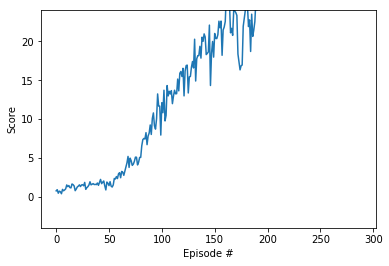

In [3]:
def plot_scores(scores, fig_indicator="normal"):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.ylim((-4, 35))
    plt.show()
    
    fig_name = "Results/Figure_" + fig_indicator + ".png"
    fig.savefig(fig_name)
    
    np.save("Results/scores_" + fig_indicator + ".npy", scores)
    

def ddpg(n_episodes=2000, max_t=700):
    scores_deque = deque(maxlen=100)
    
    scores = []
    max_score = -np.Inf
    
    tt = time.time()
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        score = np.zeros(num_agents)                          # initialize the score (for each agent)
        for t in range(max_t):
            
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]        # send the action to the environment

            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished            
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            
            if np.any(dones):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))                
                
        if i_episode == 200:
            for param_group in agent.actor_optimizer.param_groups:
                param_group['lr'] = 1e-4 # 1e-3

            for param_group in agent.critic_optimizer.param_groups:
                param_group['lr'] = 1e-4 #3e-4
                                            
        if i_episode == 240:
            for param_group in agent.actor_optimizer.param_groups:
                param_group['betas'] = (0, 0) 
            
            for param_group in agent.actor_optimizer.param_groups:
                param_group['lr'] = 0# 1e-3

            for param_group in agent.critic_optimizer.param_groups:
                param_group['lr'] = 0 #3e-4
        
        print('\rEpisode {}\tAverage Score: {:.2f} \tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), np.mean(score)))   
        if i_episode % 100 == 0 or np.mean(scores_deque) >= 30.0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
            elapsed = time.time() - tt # https://stackoverflow.com/questions/5849800/what-is-the-python-equivalent-of-matlabs-tic-and-toc-functions
            print('\t Elapsed Time: {:.2f}'.format(elapsed), 'seconds')
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break 
            
    return scores    

print(['buffer_size = ', int(BUFFER_SIZE), 'batch_size = ', int(BATCH_SIZE), 'gamma=', GAMMA, 
       'tau=', TAU, 'lr_actor= ', LR_ACTOR, 'lr_critic=',LR_CRITIC, 'weight_decay=', WEIGHT_DECAY])
tt = time.time()
scores = ddpg(n_episodes=350, max_t = 1400)
elapsed = time.time() - tt
plot_scores(scores, fig_indicator="ddpg_normal_soln_final")

### 4. Watch a Smart Agent!

The code below loads the trained weights from file to watch a smart agent. 

To visualize the trained environment,
 - change the __*visible_environment*__ variable to **True** in (**2. Instantiate the Environment and Agent**)
 - restart the kernel, and 
 - **skip** the previous section (**3. Train the Agent with DQN**).

In [4]:
# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

for i in range(1):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations                  # get the current state (for each agent)
    for j in range(200):
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]        # send the action to the environment
        states = env_info.vector_observations
        dones = env_info.local_done                  # see if episode has finished
        
        if np.any(dones):
            break     

In [5]:
env.close()